In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as func
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet152
from torchvision.models import ResNet152_Weights
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim

from models import VGG, ResNet
from train import train1Epoch, test1Epoch
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True
import seaborn as sns

import os
import cv2
import argparse
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from scipy.stats import pearsonr
import random

#from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
#from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, RawScoresOutputTarget
#from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device, torch.version.cuda

('cuda', '11.7')

%load_ext tensorboard
torch.backends.cudnn.benchmark = True
writer=SummaryWriter()
%tensorboard --logdir='runs/' --inspect

!start chrome http://localhost:6006/

os.environ['KMP_DUPLICATE_LIB_OK']='True'

!pip install https://download.pytorch.org/whl/nightly/cu117/torch-1.14.0.dev20221030%2Bcu117-cp39-cp39-linux_x86_64.whl
!pip install https://download.pytorch.org/whl/nightly/cu117/torchvision-0.15.0.dev20221030%2Bcu117-cp39-cp39-linux_x86_64.whl
torch.cuda.is_available(), torch.version.cuda

In [3]:
username = 'ddavilag'

In [3]:
data = pd.read_csv('data/256_images_np/data_fixed.csv')
data.drop(columns=['cardio_edema','bmi','cr','PNA','AcuteHF'], inplace=True)
data['bnpp_log'] = data.bnpp.apply(lambda x: np.log10(x))
data.bnpp_log = data.bnpp_log.astype('float32')
data.head(10)

,unique_key,bnpp,bnpp_log
0,Abachug_50267230_img1,418.0,2.621176
1,Abadik_50217497_img1,2161.0,3.334655
2,Abafouck_52403307_img1,118.0,2.071882
3,Abagash_52691625_img1,49.9,1.698101
4,Abakleem_50725934_img1,20029.0,4.301659
5,Abaphos_51936331_img1,1657.0,3.219322
6,Abcifisk_52639558_img1,120.0,2.079181
7,Abdisey_52768446_img1,283.0,2.451787
8,Abebey_51516292_img1,955.0,2.980003
9,Abefik_50148616_img1,4761.0,3.677698


DATA_PATH = f"/home/{username}/teams/dsc-180a---a14-[88137]/df_bnpp_datapaths.csv"
KEY_PATH = f"/home/{username}/teams/dsc-180a---a14-[88137]/df_bnpp_keys.csv"

df_datapaths = pd.read_csv(DATA_PATH, header=None).T.merge(pd.read_csv(KEY_PATH, header=None).T, left_index=True, right_index=True)
df_datapaths.columns = ['filepaths', 'key']
df_datapaths.key = df_datapaths.key.apply(lambda x: eval(x))
df_datapaths.filepaths = df_datapaths.filepaths.apply(lambda x: eval(x))
df_datapaths = df_datapaths.set_index('key')
#missing h5py files 7-9

cols= ['unique_key', 'bnpp_value_log', 'BNP_value']
test_df = pd.read_csv(f"/home/{username}/teams/dsc-180a---a14-[88137]/BNPP_DT_test_with_ages.csv", usecols = cols).set_index('unique_key')
train_df = pd.read_csv(f"/home/{username}/teams/dsc-180a---a14-[88137]/BNPP_DT_train_with_ages.csv", usecols = cols).set_index('unique_key')
val_df = pd.read_csv(f"/home/{username}/teams/dsc-180a---a14-[88137]/BNPP_DT_val_with_ages.csv", usecols = cols).set_index('unique_key')
print(train_df.shape, test_df.shape, val_df.shape)
train_df['heart'] = train_df['BNP_value'].apply(lambda x: int(x > 400))
test_df['heart'] = test_df['BNP_value'].apply(lambda x: int(x > 400))
val_df['heart'] = val_df['BNP_value'].apply(lambda x: int(x > 400))


train_df = train_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
test_df = test_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
val_df = val_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
print(train_df.shape, test_df.shape, val_df.shape)

train_df['filepaths'] = train_df['filepaths'].str.replace('jmryan', username)
test_df['filepaths'] = test_df['filepaths'].str.replace('jmryan', username)
val_df['filepaths'] = val_df['filepaths'].str.replace('jmryan', username)
train_df.shape, test_df.shape, val_df.shape

train_df.reset_index(names='unique_key',inplace=True)
val_df.reset_index(names='unique_key',inplace=True)
test_df.reset_index(names='unique_key',inplace=True)
#display(train_df.bnpp_value_log.describe(), val_df.bnpp_value_log.describe(),test_df.bnpp_value_log.describe())
print(np.sum(np.where(train_df.bnpp_value_log>np.log10(400), 1, 0))/train_df.shape[0])
print(np.sum(np.where(val_df.bnpp_value_log>np.log10(400), 1, 0))/val_df.shape[0])
print(np.sum(np.where(test_df.bnpp_value_log>np.log10(400), 1, 0))/test_df.shape[0])
train_df = train_df.to_numpy()
val_df = val_df.to_numpy()
test_df = test_df.to_numpy()

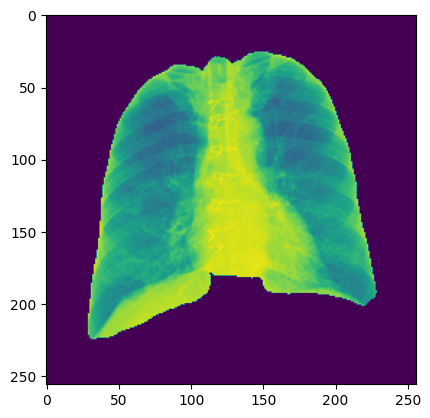

In [5]:
plt.imshow(hf['training_images'][0])

Original Image Shape: torch.Size([3, 224, 224])
Segmented Image Shape: torch.Size([3, 256, 256])


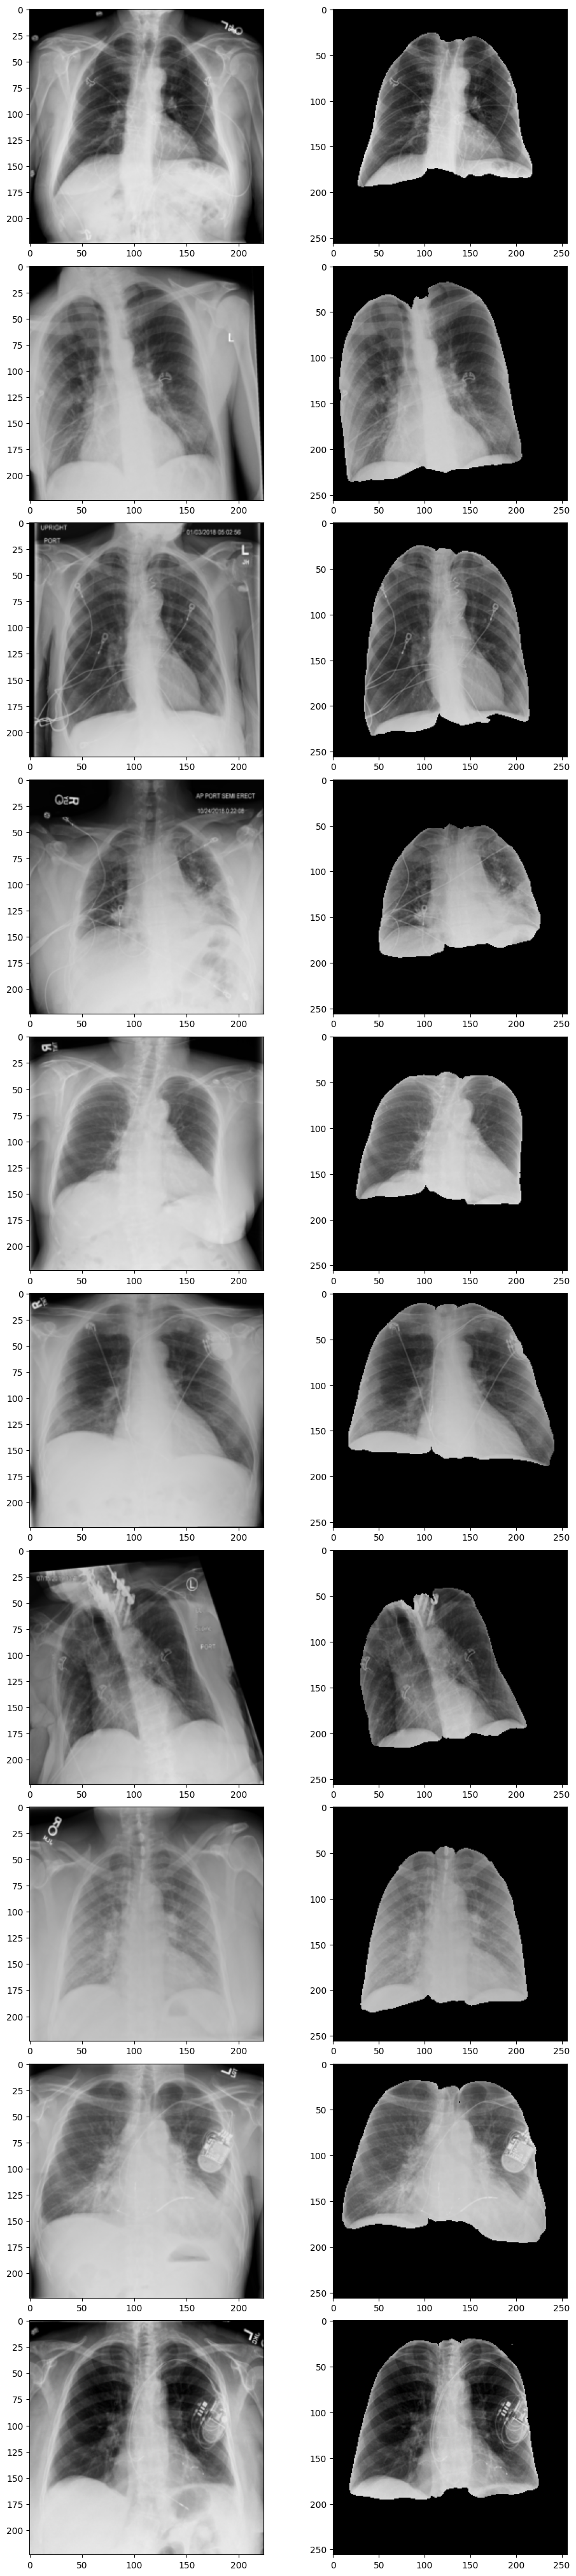

In [4]:
path = "C:/Users/david/Desktop/DSC 180A - FA22/Code/data/bnpp_224_pandas/"
hf = h5py.File('D:/Downloads/final_seg_images.hdf5','r')

fig, ax = plt.subplots(10, 2, figsize=(50, 50))
#fig.set_figheight(100)
#fig.set_figwidth(100)
fig.tight_layout()
rand_idx = random.sample(range(0,13000), 10)
counter = 0
for i in rand_idx:
    img_path = path + data.iloc[i]['unique_key'] + '/' + data.iloc[i]['unique_key'] + '_224.pandas'
    img_og = torch.load(img_path).view(1, 224, 224).expand(3, -1, -1)
    ax[counter,0].imshow(img_og.permute(1, 2, 0), cmap='gray')

    seg_img = torch.from_numpy(hf['training_images'][0:13000][i])
    seg_img = torch.reshape(seg_img, (1, 256, 256)).expand(3, -1, -1)
    ax[counter,1].imshow(seg_img.permute(1, 2, 0), cmap='gray')
    counter += 1
plt.subplots_adjust(bottom=0.1, right=0.2, top=0.9,wspace=0)
print('Original Image Shape:',img_og.shape)
print('Segmented Image Shape:',seg_img.shape)
plt.show()

In [6]:
data = data.to_numpy()

In [7]:
class PreprocessedImageDataset(Dataset):
    def __init__(self, df, hf, transform=None, target_transform=None):
        self.df = df
        self.hf = hf

    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        #row = self.df.loc[idx]
        row = self.df[idx]
        #print(row)
        #returns image, bnpp value log, binary variable for edema
        #plt.imshow(self.hf[idx])
        img = torch.from_numpy(self.hf[idx])
        #plt.imshow(img)
        return torch.reshape(img, (1, 256, 256)).expand(3, -1, -1), torch.tensor(row[2], dtype=torch.float32)
        #return torch.tensor(self.hf[idx]).view(1, 224, 224).expand(3, -1, -1), row[1]#, row[3]

In [8]:
batch_size = 16 #maybe change to 16, 8
num_workers = 0
pin_memory = True

hf_train = hf['training_images'][0:13295]
train_set = PreprocessedImageDataset(df=data[0:13295], hf=hf_train) #, transform = train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)#, pin_memory=pin_memory)

hf_val = hf['training_images'][13295:14957]
df_val = data[13295:14957]
valid_set = PreprocessedImageDataset(df=df_val, hf=hf_val) #, transform = valid_transform)
#valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)#, pin_memory=pin_memory)

hf_test = hf['training_images'][14957:]
df_test = data[14957:]
test_set = PreprocessedImageDataset(df=df_test, hf=hf_test)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=num_workers)#, pin_memory=pin_memory)

In [9]:
type(hf_val)

numpy.ndarray

import time
pin_memory = True
print('pin_memory is', pin_memory)
 
for num_workers in range(0, 5): 
    #train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    #sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    start = time.time()
    for epoch in range(1, 3):
        for i, data in enumerate(train_loader):
            pass
    end = time.time()
    print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

In [10]:
train_set[0][0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

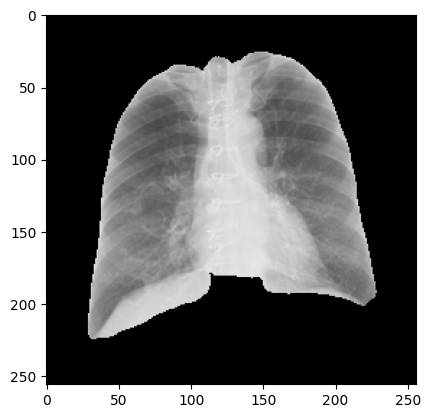

In [11]:
plt.imshow(train_set[0][0].permute(1, 2, 0),cmap='gray')
#next(iter(valid_loader))

resnet = ResNet()
#model.classifier = nn.Linear(in_features=32768, out_features=1, bias=True)
resnet.to(device)
resnet

In [12]:
#resnet = resnet152(pretrained=True)
resnet = resnet152(weights=ResNet152_Weights.DEFAULT, progress=True)
resnet.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
total_params = sum(p.numel() for p in resnet.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in resnet.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function, Mean Absolute Error
loss_fn = nn.L1Loss().to(device)
#loss_fn = nn.HuberLoss().to(device)
#loss_fn = nn.SmoothL1Loss().to(device)

# the optimizer
# TODO: need to tune 0.0001
LR = 0.00001
RHO = 0.99
optimizer = optim.Adam(resnet.parameters(), lr=LR)
#optimizer = optim.Adadelta(model.parameters(), lr=LR)

[INFO]: 58,145,857 total parameters.
[INFO]: 58,145,857 trainable parameters.


os.environ['NUM_GPU']='1'

In [14]:
#TODO:
#early stopping?
#more epochs
#save model
#print images w/ predicted/actual BNPP values
#pearson R scatterplot (predicted/actual BNPP values) 
#Docker
#run.py

epoch_number = 0

EPOCHS = 15

# the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

tlosses, vlosses = np.array([]),np.array([])

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    for param in resnet.parameters():
        param.requires_grad = True
    avg_tloss = train1Epoch(epoch_number, resnet, optimizer, loss_fn, train_loader)#, writer)
    
    for param in resnet.parameters():
        param.requires_grad = False
    with torch.no_grad():
        avg_vloss = test1Epoch(epoch_number, resnet, loss_fn, valid_loader)

    print('LOSS train {} valid {}'.format(avg_tloss, avg_vloss))
    tlosses = np.append(tlosses,avg_tloss)
    vlosses = np.append(vlosses,avg_vloss)

    epoch_number += 1
    scheduler.step(avg_vloss)

EPOCH 1:


100%|██████████| 104/104 [00:12<00:00,  8.04it/s]


LOSS train 0.7370279305104601 valid 0.5493587668125446
EPOCH 2:


100%|██████████| 104/104 [00:10<00:00,  9.47it/s]


LOSS train 0.49571473955677736 valid 0.5413693364423054
EPOCH 3:


100%|██████████| 104/104 [00:10<00:00,  9.54it/s]


LOSS train 0.4182701577958074 valid 0.5481707347700229
EPOCH 4:


100%|██████████| 104/104 [00:10<00:00,  9.51it/s]


LOSS train 0.36056629468818 valid 0.5535911613932023
EPOCH 5:


100%|██████████| 104/104 [00:10<00:00,  9.57it/s]


LOSS train 0.3171207457601522 valid 0.5436036761563557
EPOCH 6:


100%|██████████| 104/104 [00:10<00:00,  9.55it/s]


LOSS train 0.2821847809530194 valid 0.5753722448761647
EPOCH 7:


100%|██████████| 104/104 [00:10<00:00,  9.49it/s]


LOSS train 0.2598700636076583 valid 0.5458672626946981
EPOCH 8:


100%|██████████| 104/104 [00:10<00:00,  9.48it/s]


LOSS train 0.2409646548644587 valid 0.5402051333624583
EPOCH 9:


100%|██████████| 104/104 [00:10<00:00,  9.60it/s]


LOSS train 0.23001622063445126 valid 0.5313277605634469
EPOCH 10:


100%|██████████| 104/104 [00:10<00:00,  9.58it/s]


LOSS train 0.21104505549663527 valid 0.5319568351484262
EPOCH 11:


100%|██████████| 104/104 [00:10<00:00,  9.53it/s]


LOSS train 0.20621655973752626 valid 0.5437757616432813
EPOCH 12:


100%|██████████| 104/104 [00:10<00:00,  9.48it/s]


LOSS train 0.1936932068080535 valid 0.5343674937119851
EPOCH 13:


100%|██████████| 104/104 [00:10<00:00,  9.50it/s]


LOSS train 0.18704339573171022 valid 0.5435242996766017
EPOCH 14:


100%|██████████| 104/104 [00:10<00:00,  9.57it/s]


LOSS train 0.18082611040446445 valid 0.5274233818054199
EPOCH 15:


100%|██████████| 104/104 [00:11<00:00,  9.44it/s]

LOSS train 0.1746420220401313 valid 0.5234364617902499


In [15]:
#loss on unseen test set
for param in resnet.parameters():
    param.requires_grad = False
with torch.no_grad():
    test_loss = test1Epoch(epoch_number, resnet, loss_fn, test_loader)
print(test_loss)

100%|██████████| 1662/1662 [01:03<00:00, 26.22it/s]

0.5410211788833357


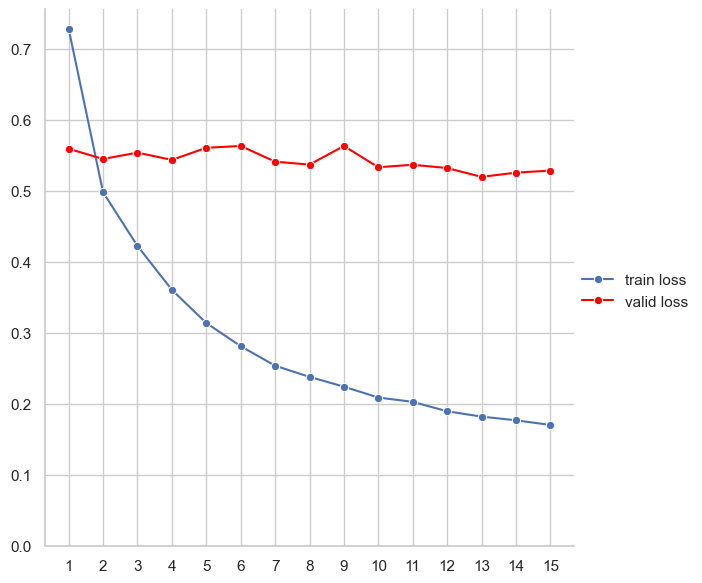

In [16]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss': tlosses,'valid loss':vlosses})
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=epochs,y=tlosses,marker='o', label='train loss')
g = g.map(sns.lineplot, x=epochs,y=vlosses,color='red',marker='o', label='valid loss')
g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

### VGG SECTION

In [12]:
import gc
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

159

In [13]:
from models import VGG, ResNet
vgg = VGG('VGG16').to(device)

In [17]:
total_params = sum(p.numel() for p in vgg.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in vgg.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function, Mean Absolute Error
loss_fn = nn.L1Loss().to(device)

LR = 0.001
optimizer = optim.Adam(vgg.parameters(), lr=LR)

[INFO]: 31,354,413 total parameters.
[INFO]: 0 trainable parameters.


In [18]:
epoch_number = 0

EPOCHS = 15

# the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

tlosses2, vlosses2 = np.array([]), np.array([])

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    for param in vgg.parameters():
        param.requires_grad = True
    avg_tloss2 = train1Epoch(epoch_number, vgg, optimizer, loss_fn, train_loader)
    
    for param in vgg.parameters():
        param.requires_grad = False
    with torch.no_grad():
        avg_vloss2 = test1Epoch(epoch_number, vgg, loss_fn, valid_loader)

    print('LOSS train {} valid {}'.format(avg_tloss2, avg_vloss2))
    tlosses2 = np.append(tlosses2,avg_tloss2)
    vlosses2 = np.append(vlosses2,avg_vloss2)

    epoch_number += 1
    scheduler.step(avg_vloss2)
    #https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/

EPOCH 1:


100%|██████████| 104/104 [00:06<00:00, 15.11it/s]


LOSS train 0.7023523015594367 valid 0.5845160550222948
EPOCH 2:


100%|██████████| 104/104 [00:06<00:00, 15.15it/s]


LOSS train 0.6462297668741068 valid 0.5643872701777861
EPOCH 3:


100%|██████████| 104/104 [00:06<00:00, 15.19it/s]


LOSS train 0.6178918585235031 valid 0.5744515815033362
EPOCH 4:


100%|██████████| 104/104 [00:06<00:00, 15.30it/s]


LOSS train 0.5972369183773886 valid 0.5971117329138976
EPOCH 5:


100%|██████████| 104/104 [00:06<00:00, 15.25it/s]


LOSS train 0.593975674697208 valid 0.546232001712689
EPOCH 6:


100%|██████████| 104/104 [00:07<00:00, 14.81it/s]


LOSS train 0.581742212803929 valid 0.5925001559349207
EPOCH 7:


100%|██████████| 104/104 [00:07<00:00, 14.26it/s]


LOSS train 0.5762618090486699 valid 0.539680160008944
EPOCH 8:


100%|██████████| 104/104 [00:06<00:00, 15.15it/s]


LOSS train 0.5648571766025323 valid 0.5629281467543199
EPOCH 9:


100%|██████████| 104/104 [00:06<00:00, 15.20it/s]


LOSS train 0.5596165229195436 valid 0.5437473631822146
EPOCH 10:


100%|██████████| 104/104 [00:06<00:00, 15.28it/s]


LOSS train 0.5575002053871339 valid 0.5634346085672195
EPOCH 11:


100%|██████████| 104/104 [00:06<00:00, 15.18it/s]


LOSS train 0.5453692179365995 valid 0.5357283502817154
EPOCH 12:


100%|██████████| 104/104 [00:06<00:00, 15.14it/s]


LOSS train 0.5430120099358323 valid 0.5721626745966765
EPOCH 13:


100%|██████████| 104/104 [00:06<00:00, 15.21it/s]


LOSS train 0.5366492903512308 valid 0.6368073961482599
EPOCH 14:


100%|██████████| 104/104 [00:06<00:00, 15.33it/s]


LOSS train 0.532870163842946 valid 0.5228974329164395
EPOCH 15:


100%|██████████| 104/104 [00:06<00:00, 14.92it/s]

LOSS train 0.5276208880719438 valid 0.5264847863178986


In [19]:
#loss on unseen test set
for param in vgg.parameters():
    param.requires_grad = False
with torch.no_grad():
    test_loss = test1Epoch(epoch_number, vgg, loss_fn, test_loader)
print(test_loss)

100%|██████████| 1662/1662 [00:10<00:00, 152.79it/s]

0.5300695016782924


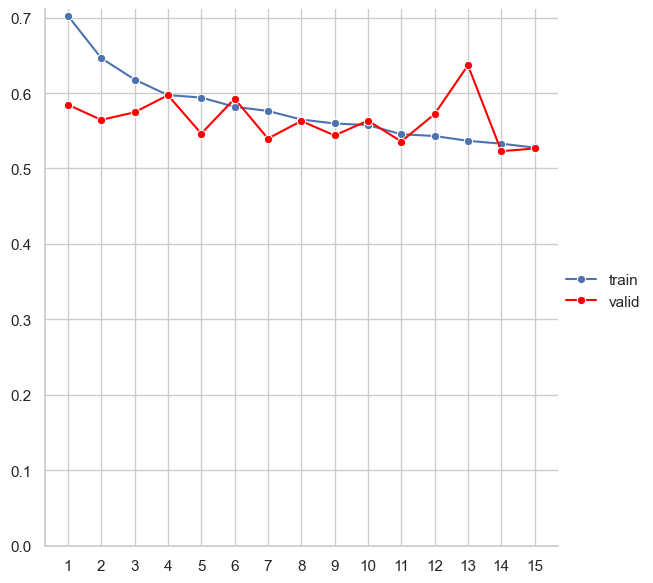

In [20]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss': tlosses2,'valid loss':vlosses2})
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=epochs,y=tlosses2,marker='o', label='train')
g = g.map(sns.lineplot, x=epochs,y=vlosses2,color='red',marker='o', label='valid')
g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

NameError: name 'tlosses' is not defined

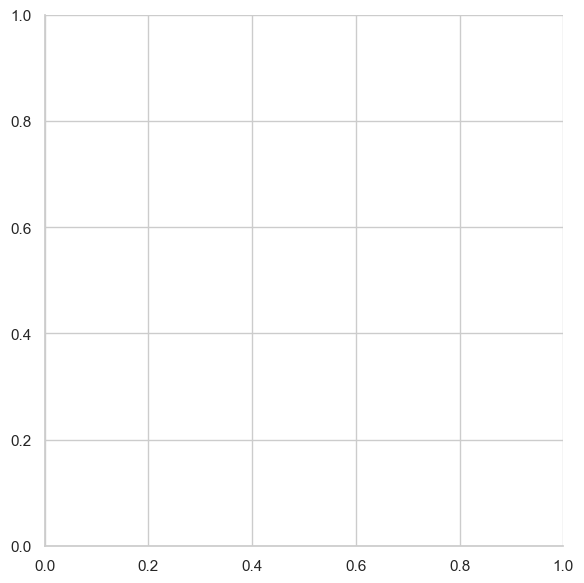

In [22]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss resnet': tlosses,'valid loss resnet':vlosses, 'train loss vgg': tlosses2,'valid loss vgg':vlosses2})
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=epochs,y=tlosses,marker='o', label='resnet train')
g = g.map(sns.lineplot, x=epochs,y=vlosses,color='red',marker='o', label='resnet valid')
g = g.map(sns.lineplot, x=epochs,y=tlosses2,color='green',marker='o', label='vgg16 train')
g = g.map(sns.lineplot, x=epochs,y=vlosses2,color='orange',marker='o', label='vgg16 valid')

g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

### Resnet AUC work

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
def AUCstarter(model, train = True):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    preds, hearts = np.array([]), np.array([])
    with torch.no_grad():
            for i, (image, _, heart) in tqdm(enumerate(train_loader), total=len(train_loader)):
                image = image.to(device, non_blocking=True)
                pred = model(image)
                hearts = np.append(hearts, heart)
                preds = np.append(preds, pred.cpu())
    prob_preds = np.power(10,preds) / (np.power(10,preds)).sum()
    y_preds = prob_preds > (np.power(10,np.log10(400))/(np.power(10,preds)).sum())
    print(f'accuracy score: {accuracy_score(hearts, y_preds)}')
    tn, fp, fn, tp = confusion_matrix(hearts, y_preds).ravel()
    print(f'\nTN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}\n')
    cf_mat = confusion_matrix(hearts, y_preds)
    print('Confusion matrix')
    df_cm = pd.DataFrame(cf_mat/np.sum(cf_mat), index = ['Normal','Edema'],
                         columns = ['Normal','Edema'])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True,vmin=0,cmap="PiYG")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    print(cf_mat)

In [18]:
AUCstarter(resnet)

  0%|          | 0/831 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
#AUC of train
resnet.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds, hearts = np.array([]), np.array([])
with torch.no_grad():
        for i, (image, _, heart) in tqdm(enumerate(train_loader), total=len(train_loader)):
            image = image.to(device, non_blocking=True)
            pred = resnet(image)
            hearts = np.append(hearts, heart)
            preds = np.append(preds, pred.cpu())
prob_preds = np.power(10,preds) / (np.power(10,preds)).sum()
y_preds1 = prob_preds > (np.power(10,np.log10(400))/(np.power(10,preds)).sum())

In [ ]:


print(f'accuracy score: {accuracy_score(hearts, y_preds)}')
tn, fp, fn, tp = confusion_matrix(hearts, y_preds).ravel()
print(f'\nTN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}\n')
cf_mat = confusion_matrix(hearts, y_preds)
print('Confusion matrix')
df_cm = pd.DataFrame(cf_mat/np.sum(cf_mat), index = ['Normal','Edema'],
                     columns = ['Normal','Edema'])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True,vmin=0,cmap="PiYG")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
print(cf_mat)

In [ ]:
#AUC of test
resnet.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds2, hearts2 = np.array([]), np.array([])
with torch.no_grad():
        for i, (image, _, heart) in tqdm(enumerate(test_loader), total=len(test_loader)):
            image = image.to(device, non_blocking=True)
            pred = resnet(image)
            hearts2 = np.append(hearts2, heart)
            preds2 = np.append(preds2, pred.cpu())
prob_preds2 = np.power(10,preds2) / (np.power(10,preds2)).sum()
y_preds2 = prob_preds2 > (np.power(10,np.log10(400))/(np.power(10,preds2)).sum())

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

print(f'accuracy score: {accuracy_score(hearts2, y_preds2)}')
tn, fp, fn, tp = confusion_matrix(hearts2, y_preds2).ravel()
print(f'\nTN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}\n')
cf_mat = confusion_matrix(hearts2, y_preds2)
print('Confusion matrix')
df_cm = pd.DataFrame(cf_mat/np.sum(cf_mat), index = ['Normal','Edema'],
                     columns = ['Normal','Edema'])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True,vmin=0,cmap="PiYG")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
print(cf_mat)

### VGG16 AUC Work

In [ ]:
#AUC of train
vgg.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds3, hearts3 = np.array([]), np.array([])
with torch.no_grad():
        for i, (image, _, heart) in tqdm(enumerate(train_loader), total=len(train_loader)):
            image = image.to(device, non_blocking=True)
            pred = vgg(image)
            hearts3 = np.append(hearts3, heart)
            preds3 = np.append(preds3, pred.cpu())
prob_preds3 = np.power(10,preds3) / (np.power(10,preds3)).sum()
y_preds3 = prob_preds3 > (np.power(10,np.log10(400))/(np.power(10,preds3)).sum())

In [ ]:
print(f'accuracy score: {accuracy_score(hearts3, y_preds3)}')
tn, fp, fn, tp = confusion_matrix(hearts3, y_preds3).ravel()
print(f'\nTN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}\n')
cf_mat = confusion_matrix(hearts3, y_preds3)
print('Confusion matrix')
df_cm = pd.DataFrame(cf_mat/np.sum(cf_mat), index = ['Normal','Edema'],
                     columns = ['Normal','Edema'])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True,vmin=0,cmap="PiYG")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
print(cf_mat)

In [ ]:
#AUC of test
vgg.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds4, hearts4 = np.array([]), np.array([])
with torch.no_grad():
        for i, (image, _, heart) in tqdm(enumerate(test_loader), total=len(test_loader)):
            image = image.to(device, non_blocking=True)
            pred = vgg(image)
            hearts4 = np.append(hearts4, heart)
            preds4 = np.append(preds4, pred.cpu())
prob_preds4 = np.power(10,preds4) / (np.power(10,preds4)).sum()
y_preds4 = prob_preds4 > (np.power(10,np.log10(400))/(np.power(10,preds4)).sum())

In [ ]:
print(f'accuracy score: {accuracy_score(hearts4, y_preds4)}')
tn, fp, fn, tp = confusion_matrix(hearts4, y_preds4).ravel()
print(f'\nTN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}\n')
cf_mat = confusion_matrix(hearts4, y_preds4)
print('Confusion matrix')
df_cm = pd.DataFrame(cf_mat/np.sum(cf_mat), index = ['Normal','Edema'],
                     columns = ['Normal','Edema'])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True,vmin=0,cmap="PiYG")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
print(cf_mat)

### Combined AUC Curves

In [ ]:
actuals = np.array([])
for i in np.arange(1823):
    actuals = np.append(actuals, test_set[i][1])

In [ ]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    return roc_auc_score(true_y, y_prob)

In [ ]:
plt.figure(figsize = (12,7))
aucVGG = plot_roc_curve(hearts2,preds2)
aucRes = plot_roc_curve(hearts,preds)
plt.gca().legend((f'vgg16 ROC: {aucVGG}',f'resnet ROC: {aucRes}'))
plt.show()

### Pearson R Plots

In [ ]:
def plot_pearson_r(y_test, y_true, color = "blue"):
    corr, _ = pearsonr(y_true, y_test)
    
    sns.scatterplot(x=y_true, y=y_test, color=color)
    plt.title('r = {}'.format(np.around(corr, 3)))

In [ ]:
#Resnet Pearson R
plot_pearson_r(preds, actuals)

In [ ]:
#VGG Pearson R
plot_pearson_r(preds2, actuals)

torch.save(model, '/home/ddavilag/private/DSC180A/DSC180A')

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn
            }, '/home/ddavilag/private/DSC180A/DSC180A/VGG16_1.pt')

#Loading the model
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()

In [ ]:
print("Q1 of arr : ", np.quantile(actuals, .25))
print("Median of arr : ", np.quantile(actuals, .50))
print("Q3 of arr : ", np.quantile(actuals, .75))

In [ ]:
indices=[0, 1, 2, 3, 4]
indices = np.array(indices)
img_num = indices.size
row_num = int(np.ceil(img_num/2))
fig_size = (4 * row_num, 4 * row_num)
fig, (ax1,ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,24))
print(fig_size)

#normal
ax1.title.set_text('NORMAL: True = {:.3f}, Predicted = {:.3f}'.format(actuals[7], preds[7]))
ax1.imshow(test_set[7][0].permute(1, 2, 0),cmap='gray')

#mild
ax2.title.set_text('MILD: True = {:.3f}, Predicted = {:.3f}'.format(actuals[1], preds[1]))
ax2.imshow(test_set[1][0].permute(1, 2, 0),cmap='gray')

#moderate
ax3.title.set_text('MODERATE: True = {:.3f}, Predicted = {:.3f}'.format(actuals[0], preds[0]))
ax3.imshow(test_set[0][0].permute(1, 2, 0),cmap='gray')

#severe
ax4.title.set_text('SEVERE: True = {:.3f}, Predicted = {:.3f}'.format(actuals[23], preds[23]))
ax4.imshow(test_set[23][0].permute(1, 2, 0),cmap='gray')

plt.show()

In [ ]:
resnet.train()
for param in resnet.parameters():
    param.requires_grad = True
resnet.eval()
target_layers = [resnet.layer4[-1]]
input_tensor = test_set[7][0].unsqueeze(0).to(device)

targets = [RawScoresOutputTarget()]

rgb_img = np.float32((test_set[7][0]).T)
target_layers = [resnet.layer4]
with GradCAM(model=resnet, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)#,eigen_smooth=True)
    cam_image = show_cam_on_image(rgb_img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*rgb_img), cam , cam_image))
print('Normal Case GradCAM')
Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)

In [ ]:
resnet.train()
for param in resnet.parameters():
    param.requires_grad = True
resnet.eval()
target_layers = [resnet.layer4[-1]]
input_tensor = test_set[1][0].unsqueeze(0).to(device)

targets = [RawScoresOutputTarget()]

rgb_img = np.float32((test_set[1][0]).T)
target_layers = [resnet.layer4]
with GradCAM(model=resnet, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)#,eigen_smooth=True)
    cam_image = show_cam_on_image(rgb_img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*rgb_img), cam , cam_image))
print('MILD Case GradCAM')
Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)

In [ ]:
resnet.train()
for param in resnet.parameters():
    param.requires_grad = True
resnet.eval()
target_layers = [resnet.layer4[-1]]
input_tensor = test_set[0][0].unsqueeze(0).to(device)

targets = [RawScoresOutputTarget()]

rgb_img = np.float32((test_set[0][0]).T)
target_layers = [resnet.layer4]
with GradCAM(model=resnet, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)#,eigen_smooth=True)
    cam_image = show_cam_on_image(rgb_img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*rgb_img), cam , cam_image))
print('MODERATE Case GradCAM')
Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)

In [ ]:
resnet.train()
for param in resnet.parameters():
    param.requires_grad = True
resnet.eval()
target_layers = [resnet.layer4[-1]]
input_tensor = test_set[23][0].unsqueeze(0).to(device)

targets = [RawScoresOutputTarget()]

rgb_img = np.float32((test_set[23][0]).T)
target_layers = [resnet.layer4]
with GradCAM(model=resnet, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)#,eigen_smooth=True)
    cam_image = show_cam_on_image(rgb_img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*rgb_img), cam , cam_image))
print('SEVERE Case GradCAM')
Image.fromarray(images).transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)